# Desafio 1
## Alumno: Maxim Dorogov

Consigna del desafío 1
1. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido la similaridad según el contenido del texto y la etiqueta de clasificación.

2. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

3. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial y ComplementNB.

4. Transponer la matriz documento-término. De esa manera se obtiene una matriz término-documento que puede ser interpretada como una colección de vectorización de palabras. Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente".

In [62]:
from pprint import pprint
from typing import Literal
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB, ComplementNB

In [63]:
data_train = fetch_20newsgroups(
    subset='train', remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(
    subset='test', remove=('headers', 'footers', 'quotes'))

In [64]:
print(data_test.keys())
pprint(data_test.data[0])

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
('I am a little confused on all of the models of the 88-89 bonnevilles.\n'
 'I have heard of the LE SE LSE SSE SSEI. Could someone tell me the\n'
 'differences are far as features or performance. I am also curious to\n'
 'know what the book value is for prefereably the 89 model. And how much\n'
 'less than book value can you usually get them for. In other words how\n'
 'much are they in demand this time of year. I have heard that the mid-spring\n'
 'early summer is the best time to buy.')


### Ejercicio 1

In [65]:
VEC_TYPE: Literal['tidf', 'count'] = 'tidf'

if VEC_TYPE == 'tidf':
    vectorizer = TfidfVectorizer()
elif VEC_TYPE == 'count':
    vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_train)


NearestNeighbors(metric='cosine')

Las filas de X_test y X_train son indices de los documentos y las columnas
representan la frecuencia Tfidf de cada termino (palabra) en el corpus.

In [66]:
SEED = 42  # reproducibility
random.seed(SEED)

doc_indexes = random.sample(range(len(data_test.data)), 5)
print(f"Seed: {SEED} | Indices de documentos: {doc_indexes}")

Seed: 42 | Indices de documentos: [5238, 912, 204, 6074, 2253]


Buscamos 5 documentos mas similares dentro del *codex* para cada uno de los indices de documentos seleccionados.


In [67]:
N_DOCS = 5

for doc_index in doc_indexes:

    # devuelve distancias y su correspondiente indice 
    # (menor distancia -> mayor similitud)
    distances, indices = knn.kneighbors(X_test[doc_index], n_neighbors=N_DOCS)
    distances, indices = distances.squeeze(), indices.squeeze()
    print(f"\n Query doc: {doc_index} | "
          f"Query Cat: {data_train.target_names[data_train.target[doc_index]]}")
    
    for i in range(N_DOCS):
        category_idx = data_train.target[indices[i]]
        print(f" - Similar Document {indices[i]}: {distances[i]:.3f} " \
              f"- Category: {data_train.target_names[category_idx]}")


 Query doc: 5238 | Query Cat: talk.politics.mideast
 - Similar Document 2741: 0.720 - Category: talk.politics.misc
 - Similar Document 9192: 0.726 - Category: sci.electronics
 - Similar Document 6421: 0.727 - Category: talk.politics.misc
 - Similar Document 10344: 0.730 - Category: sci.space
 - Similar Document 5820: 0.730 - Category: talk.politics.misc

 Query doc: 912 | Query Cat: talk.politics.guns
 - Similar Document 8394: 0.760 - Category: comp.sys.mac.hardware
 - Similar Document 285: 0.779 - Category: comp.sys.mac.hardware
 - Similar Document 2771: 0.795 - Category: misc.forsale
 - Similar Document 3522: 0.795 - Category: comp.sys.ibm.pc.hardware
 - Similar Document 881: 0.820 - Category: comp.sys.mac.hardware

 Query doc: 204 | Query Cat: sci.crypt
 - Similar Document 3920: 0.601 - Category: soc.religion.christian
 - Similar Document 572: 0.650 - Category: soc.religion.christian
 - Similar Document 3807: 0.707 - Category: soc.religion.christian
 - Similar Document 3838: 0.709 

**Conclusiones**

Podemos ver que para todos los documentos seleccionados hay al menos un vecino que comparte la misma etiqueta auque no siempre es el vecino mas cercano.
Para analizar el contenido del texto se toma el caso del documento `2253`, en donde se observan coincidencias en categorias diferentes pero con nombres que inican una posible similaridad en cuanto al contenido i.e. tecnologia, computacion y sistemas operativos. Si vemos el texto del documento que minimiza la distancia vemos que pertenece a la categoria `comp.os.ms-windows.misc` con una tematica muy similar y tocando los mismos temas que el 2do mejor match que cae en la categoria `comp.windows.x` y el 3er match que pertenece a `comp.sys.ibm.pc.hardware`
> NOTA: Debido a la extension de los textos no se muestran en la notebook para no complejizar la lectura.

### Ejercicio 2

In [68]:
def evaluate_model(y_true, y_pred, labels):
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(32, 32))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=labels,
        colorbar=False
    )
    plt.setp(
        disp.ax_.get_xticklabels(), 
        rotation=45, 
        ha='right', 
        rotation_mode='anchor')
    for text in disp.ax_.texts:
        text.set_fontsize(7)

In [69]:
distances, indices = knn.kneighbors(X_test, n_neighbors=1)
distances, indices = distances.squeeze(), indices.squeeze()

F1 Score: 0.5050


<Figure size 3200x3200 with 0 Axes>

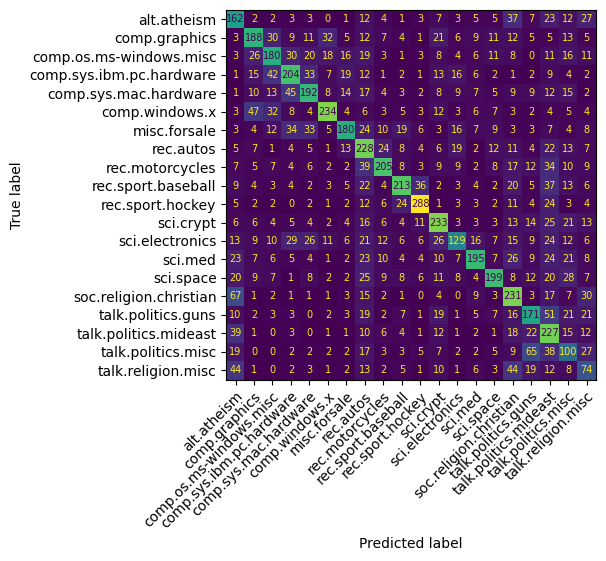

In [70]:
y_pred = data_train.target[indices]
y_true = data_test.target

evaluate_model(y_true, y_pred, labels=data_train.target_names)

**Conclusiones**


Vemos que en promedio, en terminos de `f1`, este modelo es ligeramente superior a una clasificacion aleatoria, aunque la matriz de confusion indica que para ciertas clases en particular los resultados no estan mal.

### Ejercicio 3

In [71]:
model = MultinomialNB()
model.fit(X_train, data_train.target)

MultinomialNB()

F1 Score: 0.5854


<Figure size 3200x3200 with 0 Axes>

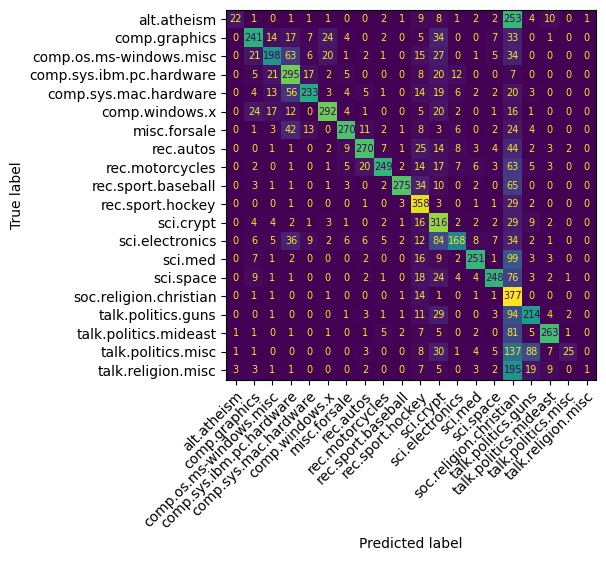

In [72]:
evaluate_model(
    data_test.target, model.predict(X_test), data_train.target_names)

F1 Score: 0.6930


<Figure size 3200x3200 with 0 Axes>

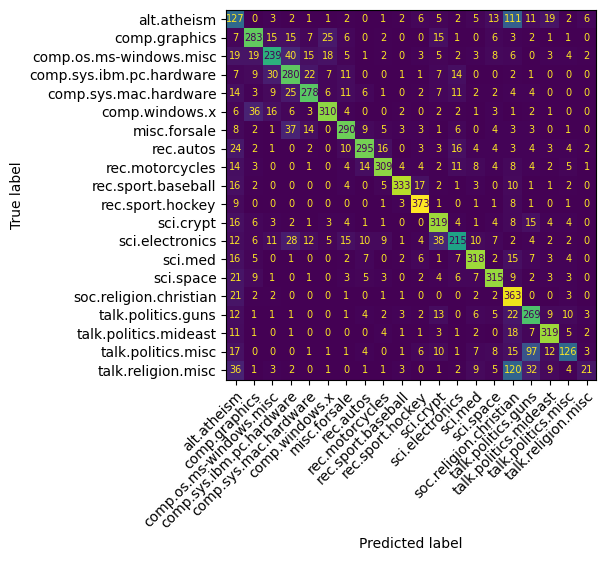

In [73]:
model = ComplementNB()
model.fit(X_train, data_train.target)
evaluate_model(data_test.target, model.predict(X_test), data_train.target_names)

Como `ComplementNB` devolvio el mejor resultado vamos a iterar sobre algunos parametros del algorimo para maximizar la metrica `f1_score`.

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.5, 1.0, 2, 5, 10],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(ComplementNB(), param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, data_train.target)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score achieved: {grid_search.best_score_}')


Best Parameters: {'alpha': 0.5, 'fit_prior': True}
Best Score achieved: 0.7600119325078438


F1 Score: 0.6961


<Figure size 3200x3200 with 0 Axes>

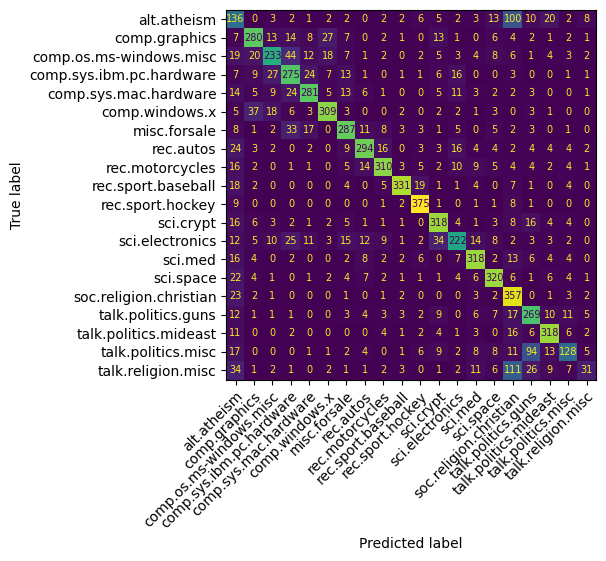

In [82]:
# Entrenamos nuevamente sobre todo el conjunto de train y evaluamos en test
best_model = ComplementNB(**grid_search.best_params_)
best_model.fit(X_train, data_train.target)
y_pred = best_model.predict(X_test)
evaluate_model(y_true, y_pred, labels=data_train.target_names)

**Conclusiones**


Tanto Multinomial como Complement Bayes superan al resultado de la clasificacion inicial, siendo este ultimo el mejor dado a que es una de las opciones de naive bayes mas performantes cuando se trata de datos desbalanceados. Si bien, en promedio, ambos son mejores que el primer resultado, penalizan siertas categorias como `talk.religion.misk` donde la cofusion con `soc.religion.christian` es alta pero dado al titulo de las categorias podemos asumir que estas son semanticamente parecidas y utilizan terminos con frecuencias similares. Se aplico GridSearch para optimizar los hiperparametros del modelo con el fin de maximizar la metrica de calidad pero no se observo una mejora significativa en el rendimiento.


### Ejercicio 4

In [ ]:
X_train_arr = X_train.toarray()
X_test_arr = X_test.toarray()

term_doc_train = X_train_arr.T
term_doc_test = X_test_arr.T

# El num de fila es el id del termino, y el valor por fila es la codificacion
# que recibe el termino para todo el codex. El valor en [fila, col] es el valor
# que representa al termino por cada documento indexado por col.

# Mapeo id a termino para el codex
idx2word = {i: word for word, i in vectorizer.vocabulary_.items()}

words = ['feature', 'have', 'demand', 'model', 'differences']
word_indexes = [vectorizer.vocabulary_[word] for word in words]

print("Selected words:", words)
print("Selected indices:", word_indexes)

Selected words: ['feature', 'have', 'demand', 'model', 'differences']
Selected indices: [39833, 45885, 32737, 62746, 33605]


In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(term_doc_train)

NearestNeighbors(metric='cosine')

In [ ]:
len(vectorizer.vocabulary_.items())

101631

In [ ]:
print(term_doc_train[0].shape)
print(term_doc_test[0].shape)
term_doc_train.shape

(11314,)
(7532,)


(101631, 11314)

La codificacion de cada palabra va a depender del largo del dataset, por ende en este experimento
se realiza la busqueda sobre el mismo dataset usado para entrenar el modelo. Se excluyen las palabras en la posicion 0 ya que estas son la misma palabra.

In [ ]:
N_WORDS = 6 # 5 palabras pedidas + la usada para el query

distances, indices = knn.kneighbors(
    term_doc_train[word_indexes], n_neighbors=N_WORDS)

In [ ]:
for query_word, found_words_indexes, found_dist in zip(words, indices, distances):
    print(f'Query word: {query_word}')

    # Skipeo primer match, es la misma palabra query
    for i in range(1, N_WORDS):
        print(f' - Similar Word: {idx2word[found_words_indexes[i]]} | Distance: {found_dist[i]:.3f}')

Query word: feature
 - Similar Word: pointer | Distance: 0.672
 - Similar Word: proceed | Distance: 0.731
 - Similar Word: zepher | Distance: 0.732
 - Similar Word: braindeads | Distance: 0.732
 - Similar Word: dilmore | Distance: 0.732
Query word: have
 - Similar Word: to | Distance: 0.422
 - Similar Word: the | Distance: 0.465
 - Similar Word: and | Distance: 0.475
 - Similar Word: that | Distance: 0.504
 - Similar Word: of | Distance: 0.520
Query word: demand
 - Similar Word: aggresively | Distance: 0.647
 - Similar Word: shortage | Distance: 0.746
 - Similar Word: pricey | Distance: 0.792
 - Similar Word: minivans | Distance: 0.797
 - Similar Word: structuring | Distance: 0.798
Query word: model
 - Similar Word: toward | Distance: 0.717
 - Similar Word: gound | Distance: 0.801
 - Similar Word: candian | Distance: 0.801
 - Similar Word: 047 | Distance: 0.801
 - Similar Word: 022 | Distance: 0.801
Query word: differences
 - Similar Word: v2 | Distance: 0.612
 - Similar Word: helping 

**Conclusiones**

No se observa ninguna similitud semantica ya que la codificacion asociada a cada palabra es formada a partir de la frecuencia de aparicion en un documento ponderado por un factor, las palabras que minimizan la distancia coseno no reflejan relaciones semanticas sino una similitud basada en la ocurrencia de palabras. 